In [2]:
import numpy as np, sys, os
import matplotlib.pyplot as plt
from matplotlib import colors, cm
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/utilities/"))
from plotting_utilities import sexy_axes

## Diffusion coefficients
#### Sanity check: https://www.engineeringtoolbox.com/air-thermal-diffusivity-d_2011.html

In [3]:
# Diffusivity of water vapor in air as a function of temperature [] and pressure []
# Eq 31 of Spichtinger and Gierens taken from Pruppacher and Klett 1997
def diffusivity_clams( T, p ):
    T0 = 273.15
    p0 = 101325
    Dv = 2.11*10**(-5)*(T / T0)**1.94*(p0 / p)
    return Dv

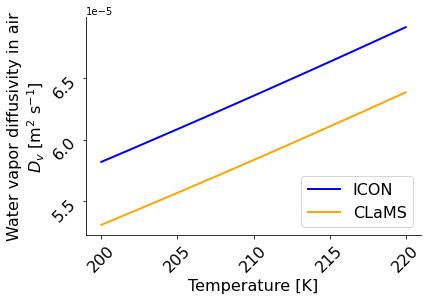

In [4]:
def diffusivity_icon( T, p ):
    Dv = 8.7602*10**(-5)*T**1.81/p
    return Dv
    
p = 22000
T = np.linspace( 200, 220, 50 )
diff_icon = np.array( [diffusivity_icon(t, p) for t in T] )
diff_clams = np.array( [diffusivity_clams(t, p) for t in T] )

fig = plt.figure()
plt.plot( T, diff_icon, lw=2, c='b', label='ICON' )
plt.plot( T, diff_clams, lw=2, c='orange', label='CLaMS' )
plt.ylabel( r'Water vapor diffusivity in air' + '\n' + '$D_v$ [m$^2$ s$^{-1}$]', fontsize=16 )
plt.xlabel( 'Temperature [K]', fontsize=16 )
plt.legend( loc='lower right', fontsize=16 )
sexy_axes( plt.gca(), fs=16 )

# Saturation vapor mixing ratio with respect to ice
#### Sanity check: https://atmos.washington.edu/academics/classes/2002Q1/211/notes_water.html

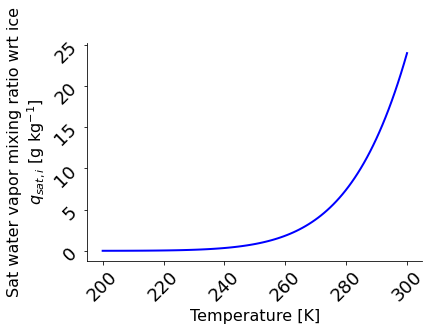

In [5]:
# Function to calculate the saturation water vapor mixing ratio wrt ice.
# t_in [=] [K] and qv [kg kg-1]
def satMR_ice(t_in):
    R = 8.314             # J mol-1 K-1
    MWw = 18.015/1000     # kg mol-1
    rhoa = 1.395
    a1 = 54.842763
    a2 = -6763.22
    a3 = -4.21
    a4 = 0.000367
    a5 = 0.0415
    a6 = 218.8
    a7 = 53.878
    a8 = -1331.22
    a9 = -9.44523
    a10 = 0.014025
    factor = a7 + a8/t_in + a9*np.log(t_in) + a10*t_in
    satVapP = a1 + a2/t_in + a3*np.log(t_in) + a4*t_in + np.arctan(a5*(t_in - a6))*factor
    satVapP = np.exp(satVapP)
    qvsati = satVapP/(R/MWw*t_in)
    return qvsati

T = np.linspace(200,300,100)
qvsati = np.array( [satMR_ice(t) for t in T] )
fig = plt.figure()
plt.plot( T, qvsati*1000., lw=2, c='b' )
plt.ylabel( r'Sat water vapor mixing ratio wrt ice' + '\n' + r'$q_{sat,i}$ [g kg$^{-1}$]', fontsize=16 )
plt.xlabel( 'Temperature [K]', fontsize=16 )
sexy_axes( plt.gca(), fs=18 )

# Length-mass relationships

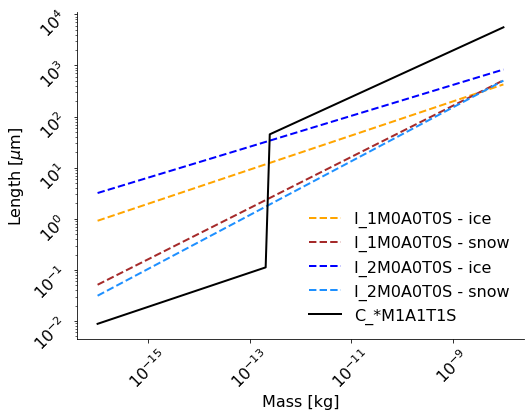

In [6]:
# Ice crystal length as a function of mass as in Spichtinger and Gierens 2009 (Tab 1),
# taken from Heymsfield and Iaquinta 2000, input mass [=] kg, length [=] m
def length( mass ):
    mass_threshold = 2.146*10**(-13) # [=] kg
    if(mass < mass_threshold):
        alpha = 1/526.1  # [=] m-1
        beta = 1/3
        L = alpha*mass**beta
    else:
        alpha = 1/0.04142
        beta = 1/2.2
        L = alpha*mass**beta
    return L

fs = 16
m = np.logspace( -16, -8, 100 )
l = [length(mm)/10**(-6) for mm in m]
fig = plt.figure( figsize=(8,6) )
a = 130 # [kg m-3] from Doms 2005 for ice
plt.plot( m, (m/a)**(1/3)*10**6, c='orange', lw=2, ls='--', label='I_1M0A0T0S - ice' )
a = 0.038
plt.plot( m, (m/a)**(1/2)*10**6, c='brown', lw=2, ls='--', label='I_1M0A0T0S - snow' )
a = 0.217
b = 0.302
plt.plot( m, a*m**b*10**6, c='b', lw=2, ls='--', label='I_2M0A0T0S - ice' )
a = 8.156
b = 0.526
plt.plot( m, a*m**b*10**6, c='dodgerblue', lw=2, ls='--', label='I_2M0A0T0S - snow' )
plt.plot( m, l, c='k', lw=2, label='C_*M1A1T1S' )
plt.legend( fontsize=fs, frameon=False )
plt.ylabel( r'Length [$\mu$m]', fontsize=fs )
plt.xlabel( 'Mass [kg]', fontsize=fs )
sexy_axes( plt.gca(), fs )
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
#fig.savefig( 'output/length-versus-mass.pdf' )
plt.show()

1.9645808605637625e-34


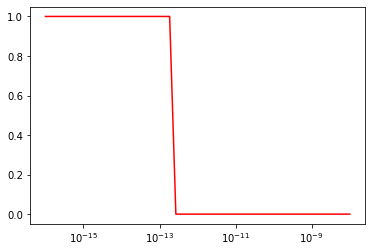

In [7]:
# Ice crystal aspect ratio as a function of mass as in Spichtinger and Gierens 2009 (Eq 17),
# derived from Heymsfield and Iaquinta 2000 and hexagonal column volume, input mass [=] kg
def aspectRatio( mass ):
    mass_threshold = 2.146*10**(-13) # [=] kg
    if(mass < mass_threshold):
        ra = 1
    else:
        rho_ice = 0.81*10**3 # [=] kg m-3
        alpha = 1/0.04142
        beta = 1/2.2
        prefactor = np.sqrt(27)*rho_ice/(8*alpha**(3/beta))
        ra = np.sqrt(prefactor)*mass**(3-beta)/(2*beta)
    return ra

m = np.logspace( -16, -8, 50 )
ar = [aspectRatio(mm) for mm in m]
print(aspectRatio(10**(-12)))
plt.figure()
plt.plot( m, ar, 'r' )
plt.gca().set_xscale( 'log' )
plt.show()

In [8]:
def capacitance(lengthscale, aspectratio):
    b = lengthscale
    a = aspectRatio*b
    eps = np.sqrt(1 - (b/a)**2)
    C = 2*a*eps/np.log((1+eps)/(1-eps))
    return C

SyntaxError: invalid syntax (<ipython-input-8-ae7ee1f489d5>, line 2)

# Terminal velocities

In [10]:
# Snow particle terminal velocity as a function of mass as in SB06 (Eq 5.93),
def terminalVelocity_icon2m( mass, rho ):
    alpha = 317 # [m s-1 kg**(-beta)]
    beta = 0.363
    rho0 = 1.225 # [kg m-3] air density at surface conditions
    gamma = 0.5
    vt_ice = alpha*mass**beta*(rho0 / rho)**gamma
    
    alpha = 27.7 # [m s-1 kg**(-beta)]
    beta = 0.216
    vt_snow = alpha*mass**beta*(rho0 / rho)**gamma
    return vt_ice, vt_snow

In [11]:
# Snow particle terminal velocity as a function of mass as in Doms 2005 (Eq 5.93),
def terminalVelocity_icon1m( mass ):
    a = 0.038 # [kg m-2]
    Ds = (mass / a)**0.5
    v0_snow = 4.9   # [m^0.75 s-1]
    vt = v0_snow*Ds**0.25
    return vt

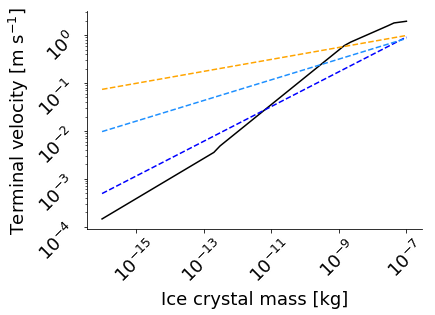

In [12]:
# Ice crystal terminal velocity as a function of mass, temperature, and pressure as in Spichtinger and Gierens 2009 (Eq 18),
# derived from Heymsfield and Iaquinta 2000, input mass [=] kg, T [=] K, p [=] Pa
def terminalVelocity_clams( mass, T, p ):
    m1_threshold = 2.146*10**(-13) # [=] kg
    m2_threshold = 2.166*10**(-9)
    m3_threshold = 4.264*10**(-8)

    if( mass <= m1_threshold ):
        gamma = 735.4
        delta = 0.42
    elif( (mass > m1_threshold) & (mass <= m2_threshold) ):
        gamma = 63292.4
        delta = 0.57
    elif( (mass > m2_threshold) & (mass <= m3_threshold) ):
        gamma = 329.8
        delta = 0.31
    else:
        gamma = 8.8
        delta = 0.096
    T0 = 233
    p0 = 30000    
    c = (p / p0)**(-0.178)*(T / T0)**(-0.394)
    vt = gamma*c*mass**delta
    return vt

fs = 18
m = np.logspace( -16, -7, 50 )
vt_clams = [terminalVelocity_clams(mm, T=237, p=23200) for mm in m]
vt_1m = [terminalVelocity_icon1m(mm) for mm in m]
vt_2m = np.array( [terminalVelocity_icon2m(mm, rho=1.225) for mm in m] )
plt.figure()
plt.plot( m, vt_clams, 'k' )
plt.plot( m, vt_1m, 'orange', ls='--' )
plt.plot( m, vt_2m[:,0], 'blue', ls='--' )
plt.plot( m, vt_2m[:,1], 'dodgerblue', ls='--' )
plt.gca().set_xscale( 'log' )
plt.gca().set_yscale( 'log' )
plt.xlabel( r'Ice crystal mass [kg]', fontsize=fs )
plt.ylabel( r'Terminal velocity [m s$^{-1}$]', fontsize=fs )
sexy_axes( plt.gca(), fs )
plt.show()

# Heat of sublimation

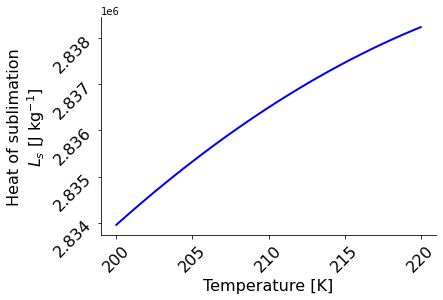

In [18]:
# Function for heat of sublimation, Rogers and Yau Ch2
# T [=] K, Li [=] J kg-1
def heatSub(T):
    a1 = 2834.1
    a2 = 0.29
    a3 = 0.004
    Tc = T - 273
    Ls = a1 - a2*Tc - a3*Tc**2
    Ls = Ls*10**3
    return Ls


T = np.linspace( 200, 220, 50 )
Ls = np.array( [heatSub(t) for t in T] )

fig = plt.figure()
plt.plot( T, Ls, lw=2, c='b' )
plt.ylabel( r'Heat of sublimation' + '\n' + '$L_s$ [J kg$^{-1}$]', fontsize=16 )
plt.xlabel( 'Temperature [K]', fontsize=16 )
sexy_axes( plt.gca(), fs=16 )

# Thermal conductivity of air

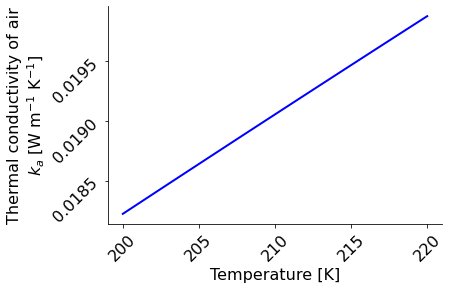

In [20]:
# Function for thermal conductivity of air, Kannuluik and Carman '51
# T [=] K, k [=] W m-1 K-1
def kAir(T):
    Tc = T - 273;
    a1 = 4.184*100
    a2 = 5.75*10**(-5)
    a3 = 0.00317
    a4 = 0.0000021

    k = a2*(1 + a3*Tc - a4*Tc**2)
    k = a1*k
    return k
            
T = np.linspace( 200, 220, 50 )
k = np.array( [kAir(t) for t in T] )

fig = plt.figure()
plt.plot( T, k, lw=2, c='b' )
plt.ylabel( r'Thermal conductivity of air' + '\n' + '$k_a$ [W m$^{-1}$ K$^{-1}$]', fontsize=16 )
plt.xlabel( 'Temperature [K]', fontsize=16 )
sexy_axes( plt.gca(), fs=16 )

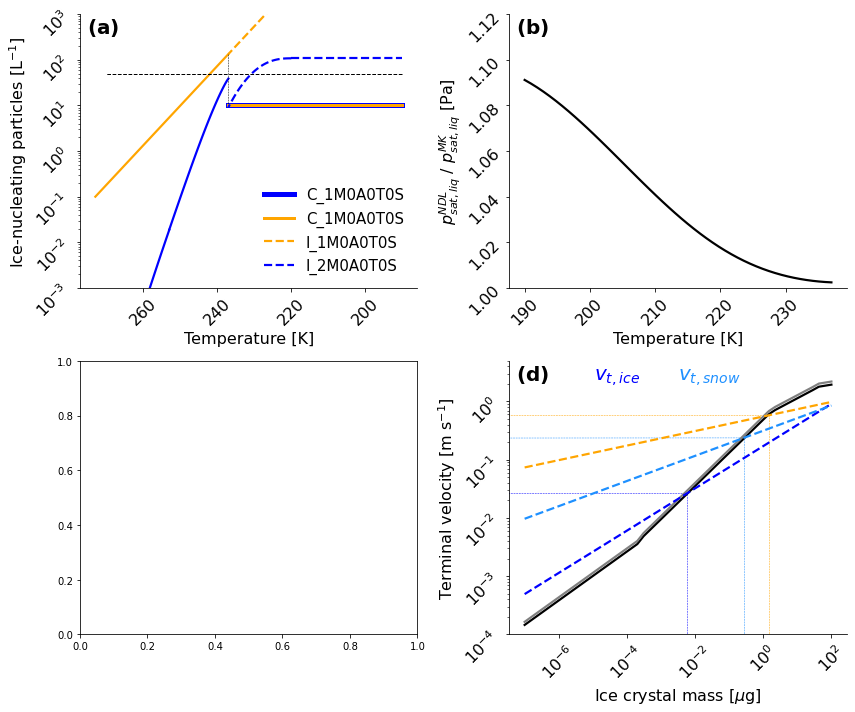

In [15]:
Tmin = 190
Thom = 237
Tmax = 273
bins = 50
fs = 16

T_cirr = np.linspace( Tmin, Thom, bins )
T_dep = np.linspace( 220, 237, bins )
T_both = np.linspace( 237, 253, bins )
T_imm = np.linspace( 253, 265, bins )
T_mp = np.linspace( Thom, Tmax, bins )
Nfletcher_cirr = 100/1000*np.exp( -0.2*(T_cirr - Tmax) ) # Divide the prefactor by 1000 for [L-1]
Nfletcher_mp = 100/1000*np.exp( -0.2*(T_mp - Tmax) )

Aimm = 2.9694*10**4/1000  # Divide the prefactor by 1000 for [L-1]
Bimm = 0.2813
Cimm = 1.1778
Nhande_imm = Aimm*np.exp( -Bimm*(T_imm - Thom)**Cimm )

Adep = 2.6543*10**4/1000  # Divide the prefactor by 1000 for [L-1]
Bdep = 0.002
Cdep = 2.5128
a = 2.7626
b = 0.0621
c = -1.3107
d = 2.6789
RHice = 130
DSF = a * np.arctan(b * (RHice-100) + c) + d
Nhande_dep = Adep*np.exp( -Bdep*(T_dep - 220)**Cdep )*DSF
Nhande_both = Adep*np.exp( -Bdep*(T_both - 220)**Cdep )*DSF + Aimm*np.exp( -Bimm*(T_both - Thom)**Cimm )


fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(12,10) )
ax[0,0].plot( [Thom, Tmin], [10, 10], c='blue', ls='-', lw=5, label='C_1M0A0T0S' )
ax[0,0].plot( [Thom, Tmin], [10, 10], c='orange', ls='-', lw=3, label='C_1M0A0T0S' )

ax[0,0].plot( T_mp, Nfletcher_mp, c='orange', ls='-', lw=2.2 )
ax[0,0].plot( T_imm, Nhande_imm, c='blue', ls='-', lw=2.2 )
ax[0,0].plot( T_both, Nhande_both, c='blue', ls='-', lw=2.2 )
ax[0,0].plot( [Thom, Thom], [Nfletcher_mp[0], 10], c='k', ls='--', lw=0.5 )

ax[0,0].plot( T_cirr, Nfletcher_cirr, c='orange', ls='--', lw=2.2, label='I_1M0A0T0S' )
ax[0,0].plot( T_dep, Nhande_dep, c='blue', ls='--', lw=2.2, label='I_2M0A0T0S' )
ax[0,0].plot( [220, Tmin], [Nhande_dep[0], Nhande_dep[0]], c='blue', ls='--', lw=2.2 )
ax[0,0].plot( [190, 270], [50, 50], c='k', ls='--', lw =1 )
ax[0,0].set_yscale( 'log' )
ax[0,0].invert_xaxis()
ax[0,0].legend( loc='lower right', fontsize=fs-1, frameon=False )
ax[0,0].text( 0.02, 0.93, r'$\bf{(a)}$', fontsize=fs+4, weight='bold', transform=ax[0,0].transAxes )
ax[0,0].set_xlabel( 'Temperature [K]', fontsize=fs )
ax[0,0].set_ylabel( 'Ice-nucleating particles [L$^{-1}$]', fontsize=fs )
ax[0,0].set_ylim([10**(-3), 10**3])
sexy_axes( ax[0,0], fs )

T = np.linspace( Tmin, Thom, bins )
a = 54.842763
b = 6763.22
c = 4.210
d = 0.000367
e = 0.0415
f = 218.8
g = 53.878
h = 1331.22
i = 9.44523
j = 0.014025
factor = g - h/T - i*np.log(T) + j*T
psat_MK = a - b/T - c*np.log(T) + d*T + np.arctan(e*(T-f))*factor
psat_MK = np.exp( psat_MK )

a = 74.8727
b = 7167.40548
c = 7.77107
d = 0.00505
psat_Nachbar = np.exp( a - b/T - c*np.log(T) + d*T )
ax[0,1].plot( T, psat_Nachbar/psat_MK, lw=2.2, c='k' )
ax[0,1].set_ylabel( r'$p_{sat,liq}^{NDL}$ / $p_{sat,liq}^{MK}$ [Pa]', fontsize=fs )
ax[0,1].set_xlabel( 'Temperature [K]', fontsize=fs )
ax[0,1].set_ylim( [1, 1.12])
ax[0,1].text( 0.02, 0.93, r'$\bf{(b)}$', fontsize=fs+4, weight='bold', transform=ax[0,1].transAxes )
sexy_axes( ax[0,1], fs )

m = np.logspace( -16, -7, 50 )
vt_clams = [terminalVelocity_clams(mm, T=237, p=23200) for mm in m]
vt_clams2 = [terminalVelocity_clams(mm, T=190, p=19000) for mm in m]
vt_icon1m = [terminalVelocity_icon1m(mm) for mm in m]
vt_icon2m = np.array( [terminalVelocity_icon2m(mm, rho=1.225) for mm in m] )
k = np.argmin( np.abs([v1-v2 for v1,v2 in zip(vt_clams,vt_icon1m)]) )
ax[1,1].plot( [m[k]*10**9, m[k]*10**9], [0, vt_icon1m[k]], ls='--', c='orange', lw=0.5 )
ax[1,1].plot( [0, m[k]*10**9], [vt_icon1m[k], vt_icon1m[k]], ls='--', c='orange', lw=0.5 )

k = np.argmin( np.abs([(v1-v2)/v1 for v1,v2 in zip(vt_clams,vt_icon2m[:,0])]) )
ax[1,1].plot( [m[k]*10**9, m[k]*10**9], [0, vt_icon2m[k,0]], ls='--', c='blue', lw=0.5 )
ax[1,1].plot( [0, m[k]*10**9], [vt_icon2m[k,0], vt_icon2m[k,0]], ls='--', c='blue', lw=0.5 )
k = np.argmin( np.abs([(v1-v2) for v1,v2 in zip(vt_clams,vt_icon2m[:,1])]) )
ax[1,1].plot( [m[k]*10**9, m[k]*10**9], [0, vt_icon2m[k,1]], ls='--', c='dodgerblue', lw=0.5 )
ax[1,1].plot( [0, m[k]*10**9], [vt_icon2m[k,0], vt_icon2m[k,1]], ls='--', c='dodgerblue', lw=0.5 )

ax[1,1].plot( m*10**9, vt_clams, c='k', ls='-', lw=2.2 )
ax[1,1].plot( m*10**9, vt_clams2, c='gray', ls='-', lw=2.2 )
ax[1,1].plot( m*10**9, vt_icon1m, c='orange', ls='--', lw=2.2 )
ax[1,1].plot( m*10**9, vt_icon2m[:,0], c='blue', ls='--', lw=2.2 )
ax[1,1].plot( m*10**9, vt_icon2m[:,1], c='dodgerblue', ls='--', lw=2.2 )
ax[1,1].set_xscale( 'log' )
ax[1,1].set_yscale( 'log' )
ax[1,1].set_xlabel( r'Ice crystal mass [$\mu$g]', fontsize=fs )
ax[1,1].set_ylabel( r'Terminal velocity [m s$^{-1}$]', fontsize=fs )
ax[1,1].text( 0.02, 0.93, r'$\bf{(d)}$', fontsize=fs+4, weight='bold', transform=ax[1,1].transAxes )
ax[1,1].text( 0.25, 0.93, r'$v_{t,ice}$', fontsize=fs+4, color='blue', transform=ax[1,1].transAxes )
ax[1,1].text( 0.5, 0.93, r'$v_{t,snow}$', fontsize=fs+4, color='dodgerblue', transform=ax[1,1].transAxes )
ax[1,1].set_ylim( [10**(-4), 5])
sexy_axes( ax[1,1], fs )

plt.tight_layout()
#fig.savefig( 'output/microphysical-processes.pdf' )